In [1]:
#Инструменты
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

#Модели
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#Работа с датасетом
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, concatenate, Input
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("healthcare_dataset.csv")
df = df.drop(columns=['Name'])
categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 
                       'Admission Type', 'Medication', 'Test Results']
df.head()

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal


In [3]:
def preprocessing(data):
    data = data.copy()
    
    # Map 'Test Results' values to numeric
    data['Test Results'] = data['Test Results'].replace({'Inconclusive': 0.5, 'Normal': 0, 'Abnormal': 1})

    # Кодировка временных данных
    data['Admission Code'] = pd.to_datetime(data['Date of Admission']).astype('int64')
    data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
    data['Discharge Code'] = pd.to_datetime(data['Discharge Date']).astype('int64')
    data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
    data['Length of Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
    data = data.drop(columns=['Date of Admission', 'Discharge Date', 'Discharge Code'])

    # One-Hot Encoding for other categorical columns
    data_encoded = pd.get_dummies(data, columns=['Gender', 'Blood Type'], drop_first=True)

    # Scaling numeric columns
    minmax_columns = ['Room Number', 'Admission Code', 'Length of Stay', 'Billing Amount']
    scaler = MinMaxScaler()
    data_encoded[minmax_columns] = scaler.fit_transform(data_encoded[minmax_columns])

    # Ordinal Encoding for ordinal columns
    ordinal_columns = ['Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']
    ordinal_encoder = OrdinalEncoder()
    data_encoded[ordinal_columns] = ordinal_encoder.fit_transform(data_encoded[ordinal_columns])
    data_encoded = data_encoded.replace({True: 1, False: 0})

######################################################################

    df = data_encoded.copy()
    embedding_columns = ['Doctor', 'Hospital']

    # Создаем словари для кодирования категорий в числа
    doctor_dict = {doctor: idx for idx, doctor in enumerate(df['Doctor'].unique())}
    hospital_dict = {hospital: idx for idx, hospital in enumerate(df['Hospital'].unique())}

    # Преобразовываем категории в числа
    df['Doctor'] = df['Doctor'].map(doctor_dict)
    df['Hospital'] = df['Hospital'].map(hospital_dict)

    # Разделяем данные на входные и выходные переменные
    X = df[embedding_columns]
    y = df['Test Results']

    # Определение размерности Embedding и создание модели
    output_dim = 5
    model = Sequential()

    # Определение входов
    doctor_input = Input(shape=(1,), name='Doctor_Input')
    hospital_input = Input(shape=(1,), name='Hospital_Input')

    # Embedding слой для 'Doctor'
    doctor_embedding = Embedding(input_dim=len(doctor_dict), output_dim=output_dim, input_length=1)(doctor_input)
    doctor_flatten = Flatten()(doctor_embedding)

    # Embedding слой для 'Hospital'
    hospital_embedding = Embedding(input_dim=len(hospital_dict), output_dim=output_dim, input_length=1)(hospital_input)
    hospital_flatten = Flatten()(hospital_embedding)

    # Объединение результатов
    merged = concatenate([doctor_flatten, hospital_flatten])

    # Определение выходного слоя
    output_layer = Dense(1, activation='linear')(merged)

    # Создание и компиляция модели
    model = Model(inputs=[doctor_input, hospital_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Обучение модели на данных
    X_train, y_train = X, y

    # Преобразование данных в формат, который можно передать в модель
    X_train_input = [X_train['Doctor'].values, X_train['Hospital'].values]

    model.fit(X_train_input, y_train, epochs=1, batch_size=32)

    # Преобразование данных в формат, который можно передать в модель
    X_data_encoded = [data_encoded['Doctor'].map(doctor_dict), data_encoded['Hospital'].map(hospital_dict)]

    # Получение весов Embedding
    embedding_weights = [layer.get_weights()[0] for layer in model.layers if 'embedding' in layer.name]

    # Присвоение значений в data_encoded
    for i in range(output_dim):
        data_encoded[f'Doctor_embedding_dim_{i}'] = X_data_encoded[0].apply(lambda x: embedding_weights[0][x, i])
        data_encoded[f'Hospital_embedding_dim_{i}'] = X_data_encoded[1].apply(lambda x: embedding_weights[1][x, i])

    # Удаление столбцов 'Doctor' и 'Hospital'
    data_encoded = data_encoded.drop(['Doctor', 'Hospital'], axis=1)

    
######################################################################
    return data_encoded

# Task 1
Выбрать подходящую таблицу данных. Построить и визуализировать дерево решений.




313/313 [==============================] - 2s 2ms/step - loss: 0.3125
   Age  Medical Condition  Insurance Provider  Billing Amount  Room Number  \
0   81                3.0                 3.0        0.744775     0.112782   
1   35                1.0                 4.0        0.945060     0.759398   
2   61                5.0                 3.0        0.732201     0.478697   
3   49                1.0                 3.0        0.455206     0.949875   
4   51                0.0                 4.0        0.348728     0.942356   

   Admission Type  Medication  Test Results  Admission Code  Length of Stay  \
0             0.0         0.0           0.5        0.809967        0.448276   
1             1.0         2.0           0.0        0.917306        0.448276   
2             1.0         2.0           0.0        0.038883        1.000000   
3             2.0         4.0           1.0        0.301205        0.000000   
4             2.0         3.0           0.0        0.538335    

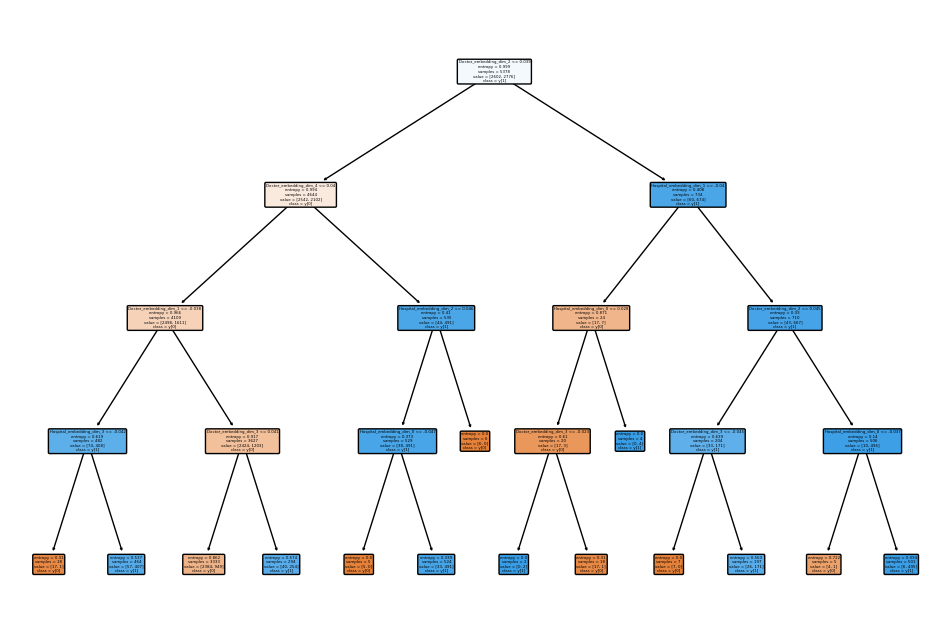

In [4]:
# Example usage
df_processed = preprocessing(df)
print(df_processed[:5])

# Getting X and Y as NumPy arrays
X = df_processed.drop('Test Results', axis=1)
Y = df_processed['Test Results']

mask = Y != 0.5
X = X[mask]
Y = Y[mask]

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Шаг 3: Обучение модели дерева решений
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Шаг 4: Визуализация дерева решений
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()

# Task 2 
Применить метод градиентного бустинга. Вычислить значимость переменных. Выдать список построенных деревьев.

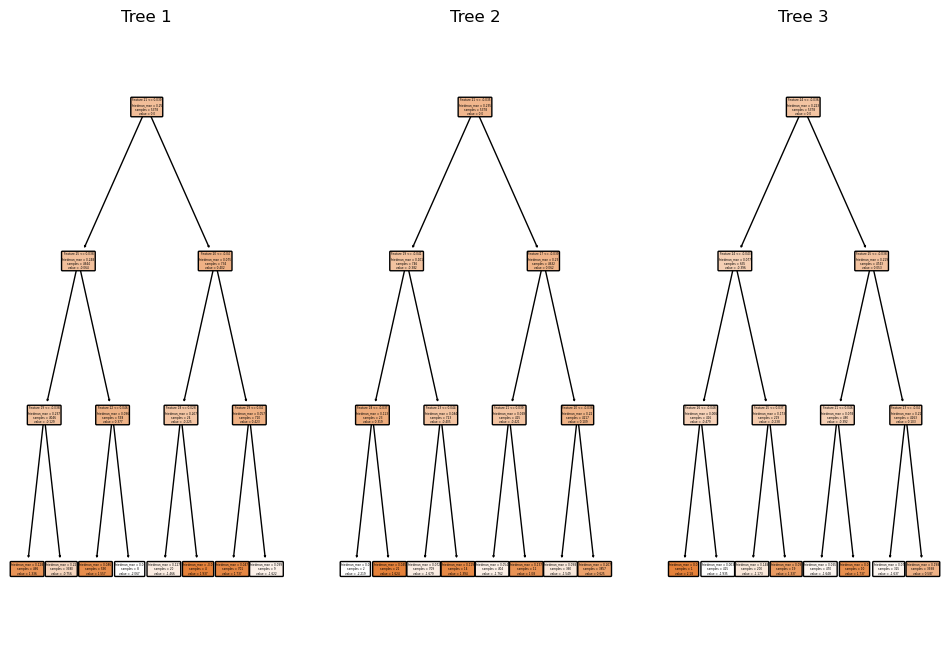

In [5]:
# Инициализация модели градиентного бустинга
clf = GradientBoostingClassifier(n_estimators=3, random_state=42)

# Обучение модели
clf.fit(X_train, y_train)

# Обучение модели
clf.predict(X_test)

plt.figure(figsize=(12, 8))

# Вывод списка построенных деревьев
for i, tree in enumerate(clf.estimators_):
    plt.subplot(1, 3, i + 1)  # Создание сетки 1x3 для отображения трех деревьев
    plot_tree(tree[0], filled=True, feature_names=[f"Feature {i}" for i in range(X.shape[1])], class_names=True, rounded=True)
    plt.title(f'Tree {i + 1}')

plt.show()

In [6]:
# Инициализация списка для хранения точности каждой переменной
accuracies = []
df = df_processed[mask]
# Перебор всех столбцов DataFrame
for column in df.columns[1:]:

    # Создание решающей функции на основе частот
    decision_function = df.groupby(column)['Test Results'].mean().round().to_dict()

    # Применение решающей функции к данным
    predictions = df[column].map(decision_function)
    
    # Вычисление точности
    accuracy = accuracy_score(df['Test Results'], predictions)
    
    # Добавление точности в список
    accuracies.append(accuracy)

# Нахождение наиболее информативной переменной
most_informative_variable = df.columns[accuracies.index(max(accuracies)) + 1]
print(f'Наиболее информативная переменная: {most_informative_variable}')

Наиболее информативная переменная: Billing Amount


# Task 3
Построить зависимость качества решения (на обучении и скользящем контроле) от числа вершин дерева.


In [27]:
def grid_search_3D(model_instance, metrics, name_variable, grid_variables, grid_k, X, Y, **kwargs):
    metric_dict = {loss_function: np.zeros((len(grid_variables), len(grid_k), 2)) for loss_function in metrics}

    variables = grid_variables[0]
    for i, variable in tqdm(enumerate(grid_variables), total=len(grid_variables), desc=f'{name_variable}={variables}'):
        variables = variable
        X_shuffled, y_shuffled = shuffle(X, Y, random_state=42)
        for j, k in enumerate(grid_k):
            # Разделение данных на обучающий и тестовый наборы
            X_train, X_test, y_train, y_test = train_test_split(X_shuffled[:k], y_shuffled[:k], test_size=0.3, random_state=42)
            model = model_instance(**kwargs)
            setattr(model, name_variable, variable)
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            for metric in metrics:
                loss_test = metric(y_test, y_pred_test)
                loss_train = metric(y_train, y_pred_train)
                metric_dict[metric][i, j] = (loss_test, loss_train)

    # Построение трехмерного графика
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    min_Z = 1000
    max_Z = -1000

    grid_x, grid_y = np.meshgrid(grid_variables, grid_k)
    for metric in metrics:
        for i, mode in enumerate(['test', 'train']):
            Z = np.log([[item[i] for item in row] for row in metric_dict[metric]])
            smooth_Z = savgol_filter(Z, window_length=int(len(grid_k)/16), polyorder=2, axis=1, mode='nearest')
            ax.plot_surface(grid_x, grid_y, smooth_Z.T, label=f"{metric.__name__} ({mode})")
            min_Z = min(smooth_Z.min(), min_Z)
            max_Z = max(smooth_Z.max(), max_Z)

    ax.set_xlabel(name_variable)
    ax.set_ylabel('k-fold')
    ax.set_zlabel('Metrics')
    ax.set_xlim([grid_x[0, 0], grid_x[-1, -1]])
    ax.set_ylim([grid_y[0, 0], grid_y[-1, -1]])
    ax.set_zlim([min_Z, max_Z])
    ax.set_title('3D Plot of Loss')
    plt.tight_layout()
    plt.show()

max_depth=4:   0%|          | 0/4 [00:00<?, ?it/s]

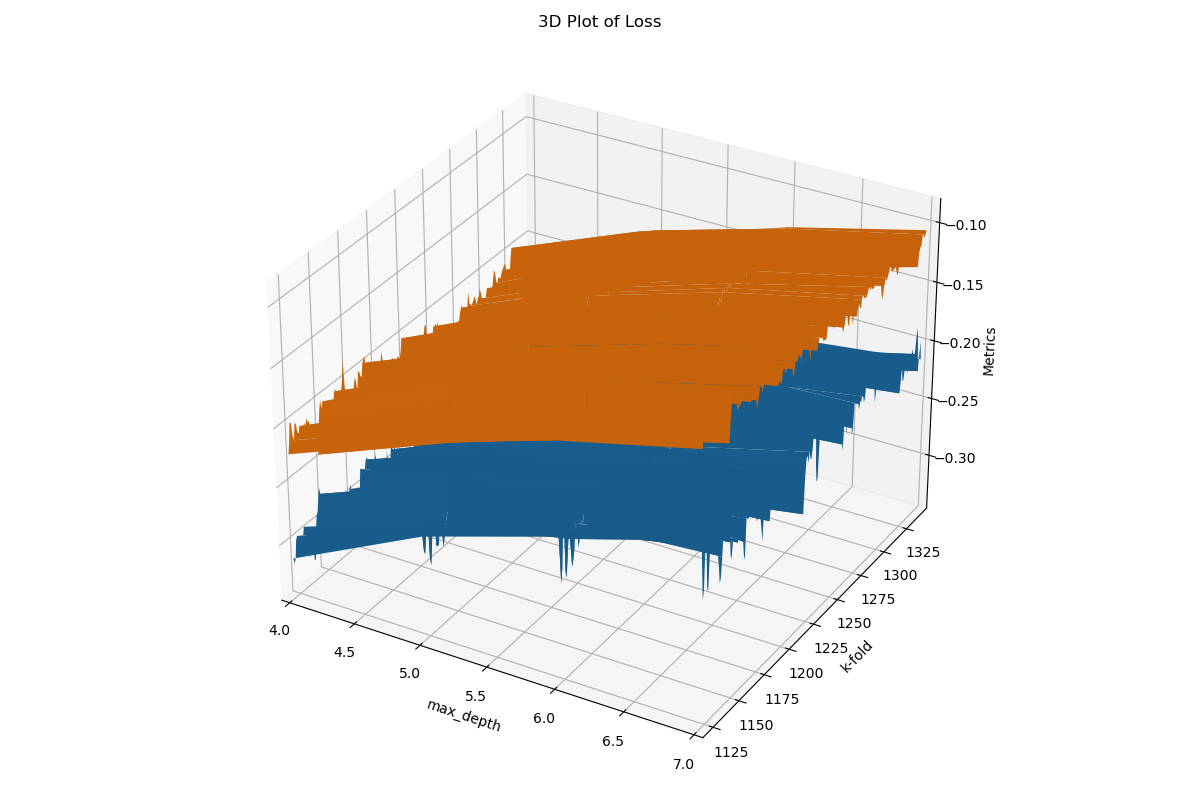

In [8]:
%matplotlib widget
#-----------------------
min_depth = 4
max_depth  = 8
step_depth = 1
#-----------------------
start_k=int(len(X)/6)
end_k=int(len(X)/5)
step_k=1
#-----------------------

grid_variable = np.arange(min_depth, max_depth, step_depth)
grid_k = np.arange(start_k, end_k, step_k)
metrics = [roc_auc_score]

model=DecisionTreeClassifier
metrics=[roc_auc_score]
grid_search_3D(model, metrics, 'max_depth', grid_variable, grid_k, X, Y, random_state=42)
#grid_search_3D(model, metrics, name_variable, grid_variables, grid_k, X, Y, **kwargs):

# Task 4
Для метода градиентного бустинга построить зависимость качества решения (на обучении и скользящем контроле) от числа деревьев.
Для разной глубины дерева нужно построить несколько зависимостей качества от числа деревьев, чтобы найти оптимальную комбинацию этих параметров.


n_estimators=5:   0%|          | 0/18 [00:00<?, ?it/s]

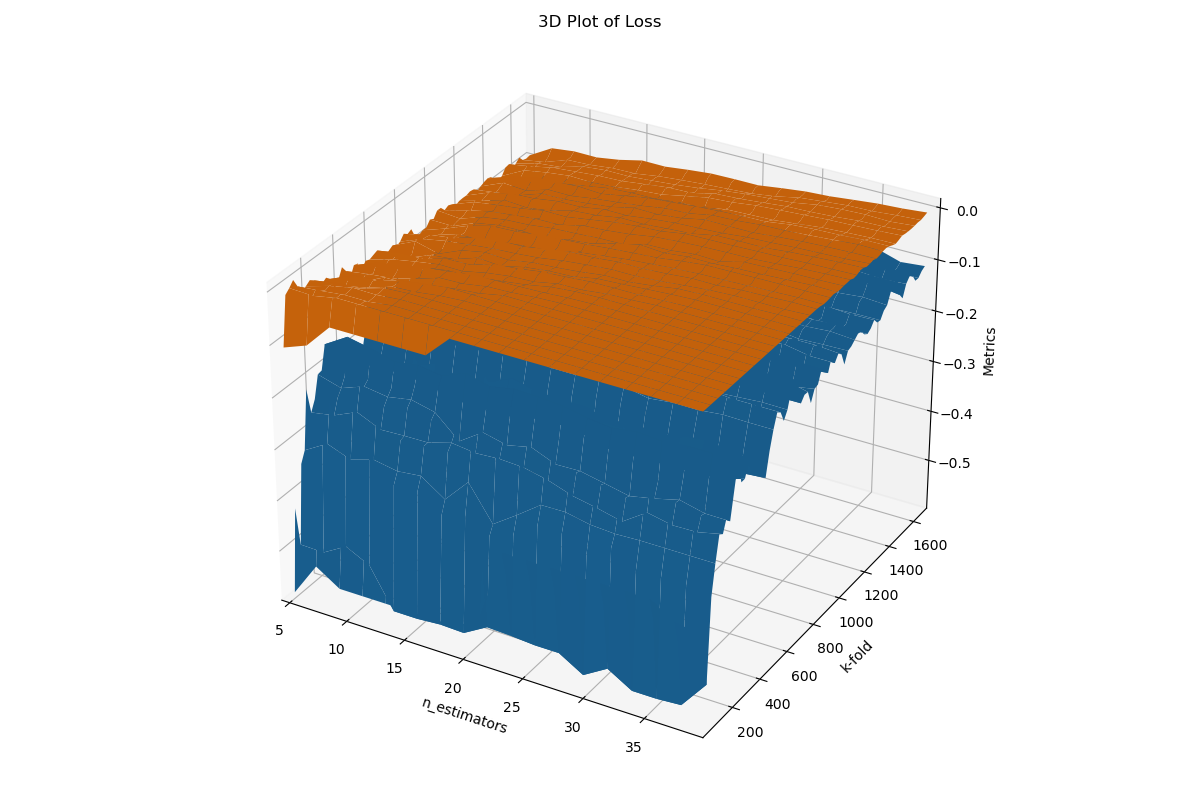

In [31]:
%matplotlib widget
# Создаем словарь для сохранения точности на обучении и тесте
#-----------------------
min_n_estimators=5
max_n_estimators=40
step_n_estimators=2
grid_variable = np.arange(min_n_estimators, max_n_estimators, step_n_estimators)
#-----------------------
start_k=int(25)
end_k=int(len(X)/4)
step_k=25
grid_k = np.arange(start_k, end_k, step_k)
#-----------------------
model= XGBClassifier
metrics=[roc_auc_score]
grid_search_3D(model, metrics, 'n_estimators', grid_variable, grid_k, X, Y, max_depth=5, random_state=42)
#grid_search_3D(model, metrics, name_variable, grid_variables, grid_k, X, Y, **kwargs):

# Task 5
Выполнить предыдущий пункт для случайного леса.

n_estimators=25:   0%|          | 0/11 [00:00<?, ?it/s]

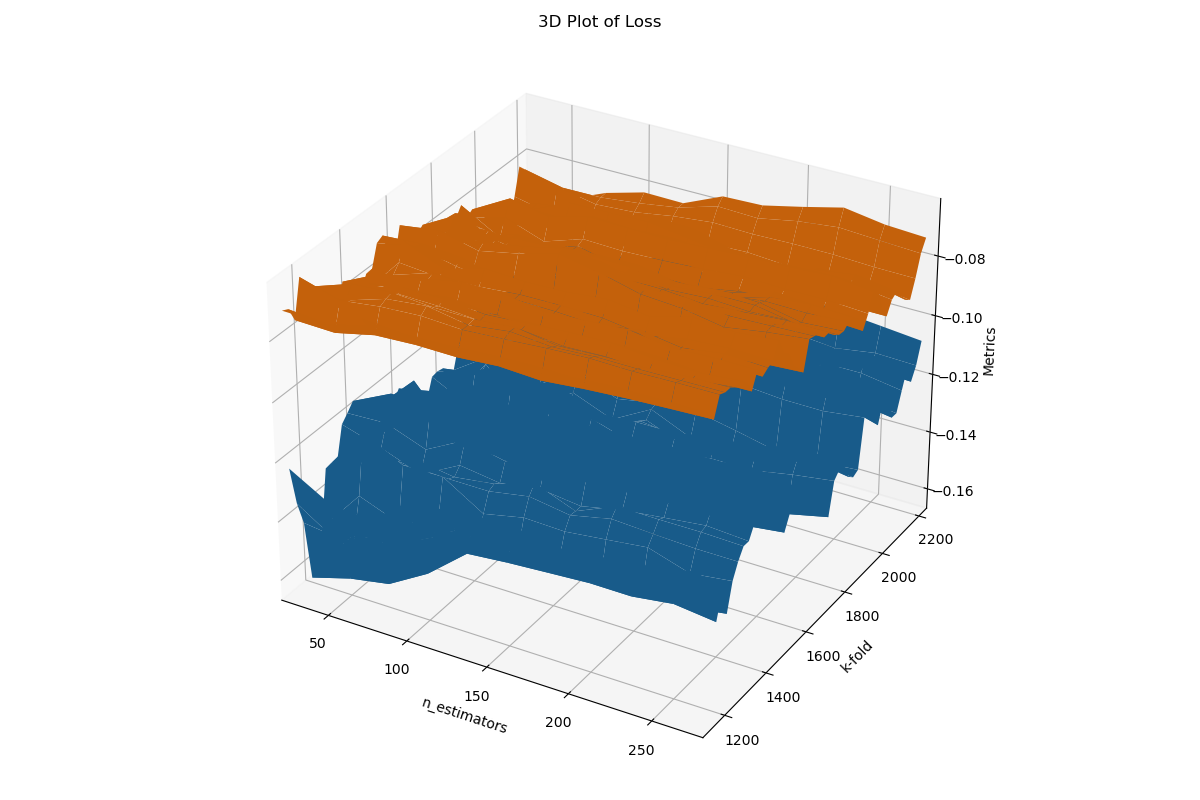

In [11]:
%matplotlib widget
# Создаем словарь для сохранения точности на обучении и тесте
#-----------------------
min_n_estimators=25
max_n_estimators=300
step_n_estimators=25
grid_variable = np.arange(min_n_estimators, max_n_estimators, step_n_estimators)
#-----------------------
start_k=int(len(X)/6)
end_k=int(len(X)/3)
step_k=25
grid_k = np.arange(start_k, end_k, step_k)
#-----------------------
model=RandomForestClassifier
metrics=[roc_auc_score]
grid_search_3D(model, metrics, 'n_estimators', grid_variable, grid_k, X, Y, max_depth=6, random_state=42)
#grid_search_3D(model, metrics, name_variable, grid_variables, grid_k, X, Y, **kwargs):